In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

import dask.bag as db
import json
import pandas as pd

docs = db.read_text('drive/MyDrive/Rahmad_Skripsi/arxiv-metadata-oai-snapshot.json').map(json.loads)

In [6]:
docs.count().compute()

2211302

In [7]:
docs.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

In [8]:
get_latest_version = lambda x: x['versions'][-1]['created']


# get only necessary fields of the metadata file
trim = lambda x: {'id': x['id'],
                  'authors': x['authors'],
                  'title': x['title'],
                  'doi': x['doi'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract'],}
# filter for papers published on or after 2019-01-01
columns = ['id','category','abstract']
docs_df = (docs.filter(lambda x: int(get_latest_version(x).split(' ')[3]) > 2018)
           .map(trim).
           compute())

# convert to pandas
docs_df = pd.DataFrame(docs_df)

In [9]:
docs_df.to_csv("trimmed_arxiv_docs.csv", index=False)

In [10]:
docs_df.head()

id                                            authors  \
0  0704.0033  Maxim A. Yurkin, Valeri P. Maltsev, Alfons G. ...   
1  0704.0038                Maxim A. Yurkin, Alfons G. Hoekstra   
2  0704.0479                                          T.Geisser   
3  0704.1445            Yasha Gindikin and Vladimir A. Sablikov   
4  0704.1476                                       Chris Austin   

                                               title  \
0  Convergence of the discrete dipole approximati...   
1  The discrete dipole approximation: an overview...   
2               The affine part of the Picard scheme   
3  Deformed Wigner crystal in a one-dimensional q...   
4  TeV-scale gravity in Horava-Witten theory on a...   

                                                 doi  \
0    10.1364/JOSAA.23.002578 10.1364/JOSAA.32.002407   
1  10.1016/j.jqsrt.2007.01.034 10.1016/j.jqsrt.20...   
2                                               None   
3                         10.1103/PhysRevB.76.045122   
4                                               None   

                               category  \
0     [physics.optics, physics.comp-ph]   
1     [physics.optics, physics.comp-ph]   
2                    [math.AG, math.KT]   
3  [cond-mat.str-el, cond-mat.mes-hall]   
4                              [hep-th]   

                                            abstract  
0    We performed a rigorous theoretical converge...  
1    We present a review of the discrete dipole a...  
2    We describe the maximal torus and maximal un...  
3    The spatial Fourier spectrum of the electron...  
4    The field equations and boundary conditions ...

In [11]:
df = pd.read_csv("./trimmed_arxiv_docs.csv")

<ipython-input-11-00dad3b2a3e3>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./trimmed_arxiv_docs.csv")


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776433 entries, 0 to 776432
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        776433 non-null  object
 1   authors   776433 non-null  object
 2   title     776433 non-null  object
 3   doi       277883 non-null  object
 4   category  776433 non-null  object
 5   abstract  776433 non-null  object
dtypes: object(6)
memory usage: 35.5+ MB


In [13]:
df.shape

(776433, 6)

In [14]:
df['abstract_word_count'] = docs_df['abstract'].apply(lambda x: len(x.strip().split()))

In [15]:
df['abstract'].describe(include='all')

count                                                776433
unique                                               776288
top         arXiv admin note: This submission has been w...
freq                                                      3
Name: abstract, dtype: object

In [16]:
df.drop_duplicates(['abstract',], inplace=True)
df['abstract'].describe(include='all')

count                                                776288
unique                                               776288
top         We performed a rigorous theoretical converge...
freq                                                      1
Name: abstract, dtype: object

In [17]:
df = df.sample(10000, random_state=42)

In [18]:
from tqdm import tqdm

from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz

In [19]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS 
import en_core_sci_lg

In [20]:
parser = en_core_sci_lg.load()
parser.max_length = 7000000 

def spacy_tokenizer(sentence):
    ''' Function to preprocess text of scientific papers 
        (e.g Removing Stopword and puntuations)'''
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ] 
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ] 
    mytokens = " ".join([i for i in mytokens]) 
    return mytokens

In [21]:
import string

punctuations = string.punctuation #list of punctuation to remove from text
stopwords = list(STOP_WORDS)
stopwords[:10]

['became',
 'into',
 'should',
 'hundred',
 "n't",
 'mine',
 'nor',
 'than',
 'hereby',
 'ours']

In [22]:
tqdm.pandas()
df["processed_text"] = df["abstract"].progress_apply(spacy_tokenizer)

100%|██████████| 10000/10000 [09:29<00:00, 17.55it/s]


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [24]:
text = df['processed_text'].values
X = vectorize(text, 2 ** 12) 
X.shape

(10000, 4096)

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42) #Keep 95% of the variance
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(10000, 2796)

In [26]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from sklearn import metrics

In [27]:
k = 20 # optimal k found in elbow plot
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['kmean_clusters'] = y_pred

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [28]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=9184ec5bc1b40a8ee522f657eb6825b648e5c74b2f5f8ace539ff4af334c2fb8
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=369621a486ab519ebbd7b046afdf4b61bf19f0842ef86bb78b561efebab65259
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [29]:
from umap import UMAP

In [30]:
# UMAP Definition:
umap_embeddings = UMAP(n_neighbors=100, min_dist=0.3, n_components=2)

In [36]:
X_umap = umap_embeddings.fit_transform(X_reduced)

In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.125s...
[t-SNE] Computed neighbors for 10000 samples in 68.706s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.316577
[t-SNE] KL divergence after 50 iterations with early exaggeration: 83.046112
[t-SNE] KL divergence after 1000 iterations: 2.564157


<ipython-input-32-c642d26ce12e>:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], palette=palette)


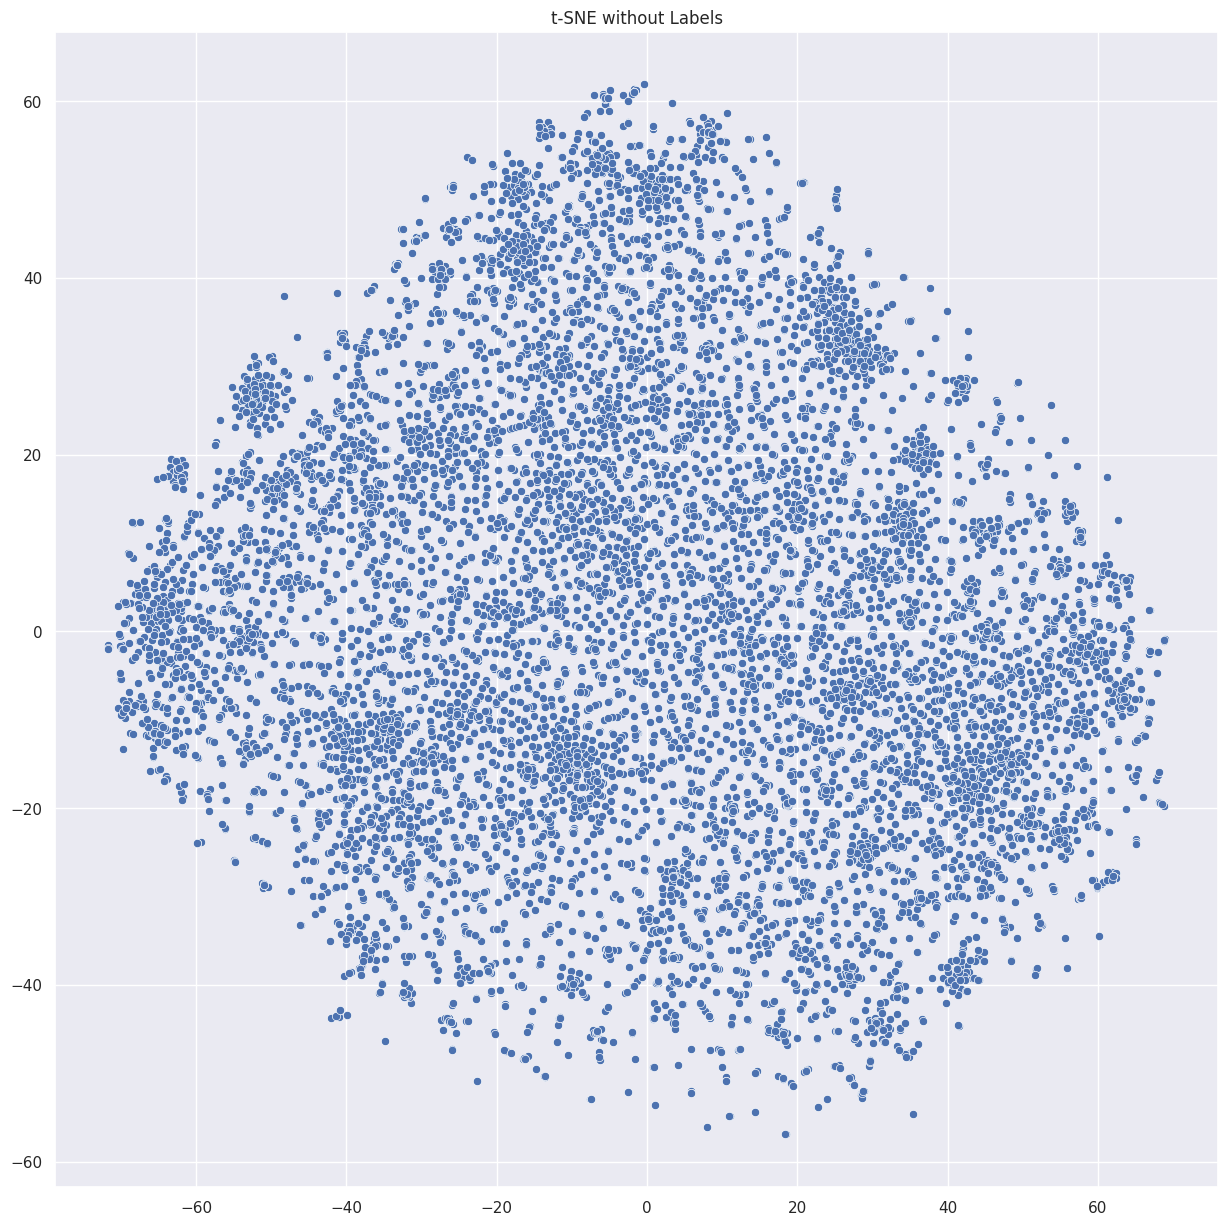

In [32]:
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], palette=palette)
plt.title('t-SNE without Labels')
plt.savefig("t-sne_arxvid.png")
plt.show()

<ipython-input-37-b507ca684b7f>:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], palette=palette)


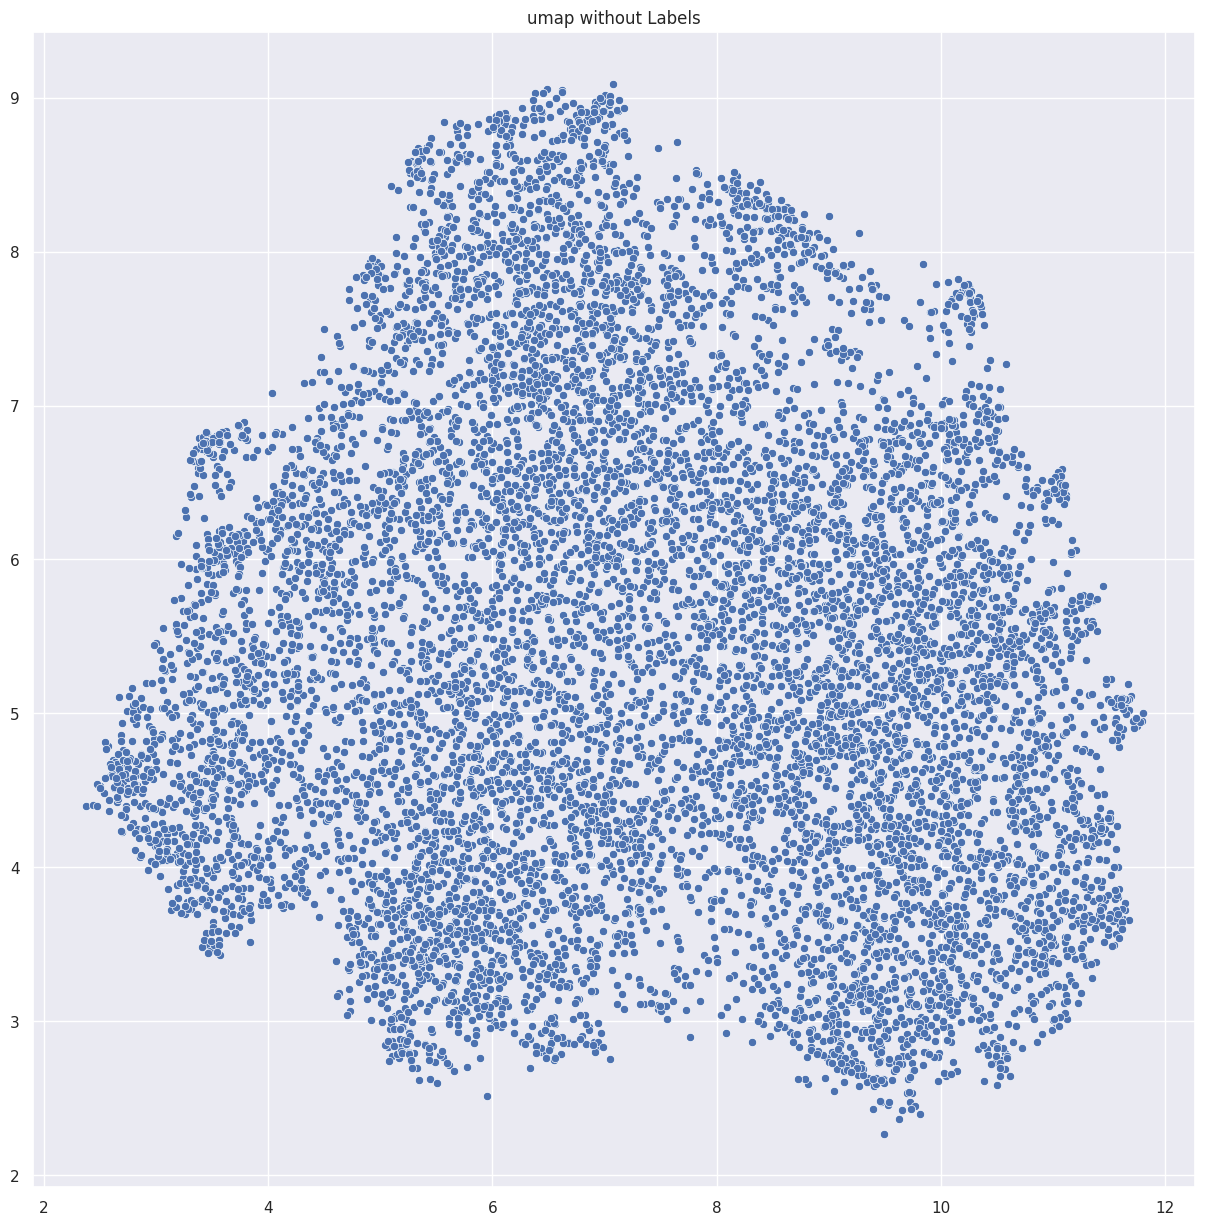

In [37]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], palette=palette)
plt.title('umap without Labels')
plt.savefig("umap_arxvid.png")
plt.show()

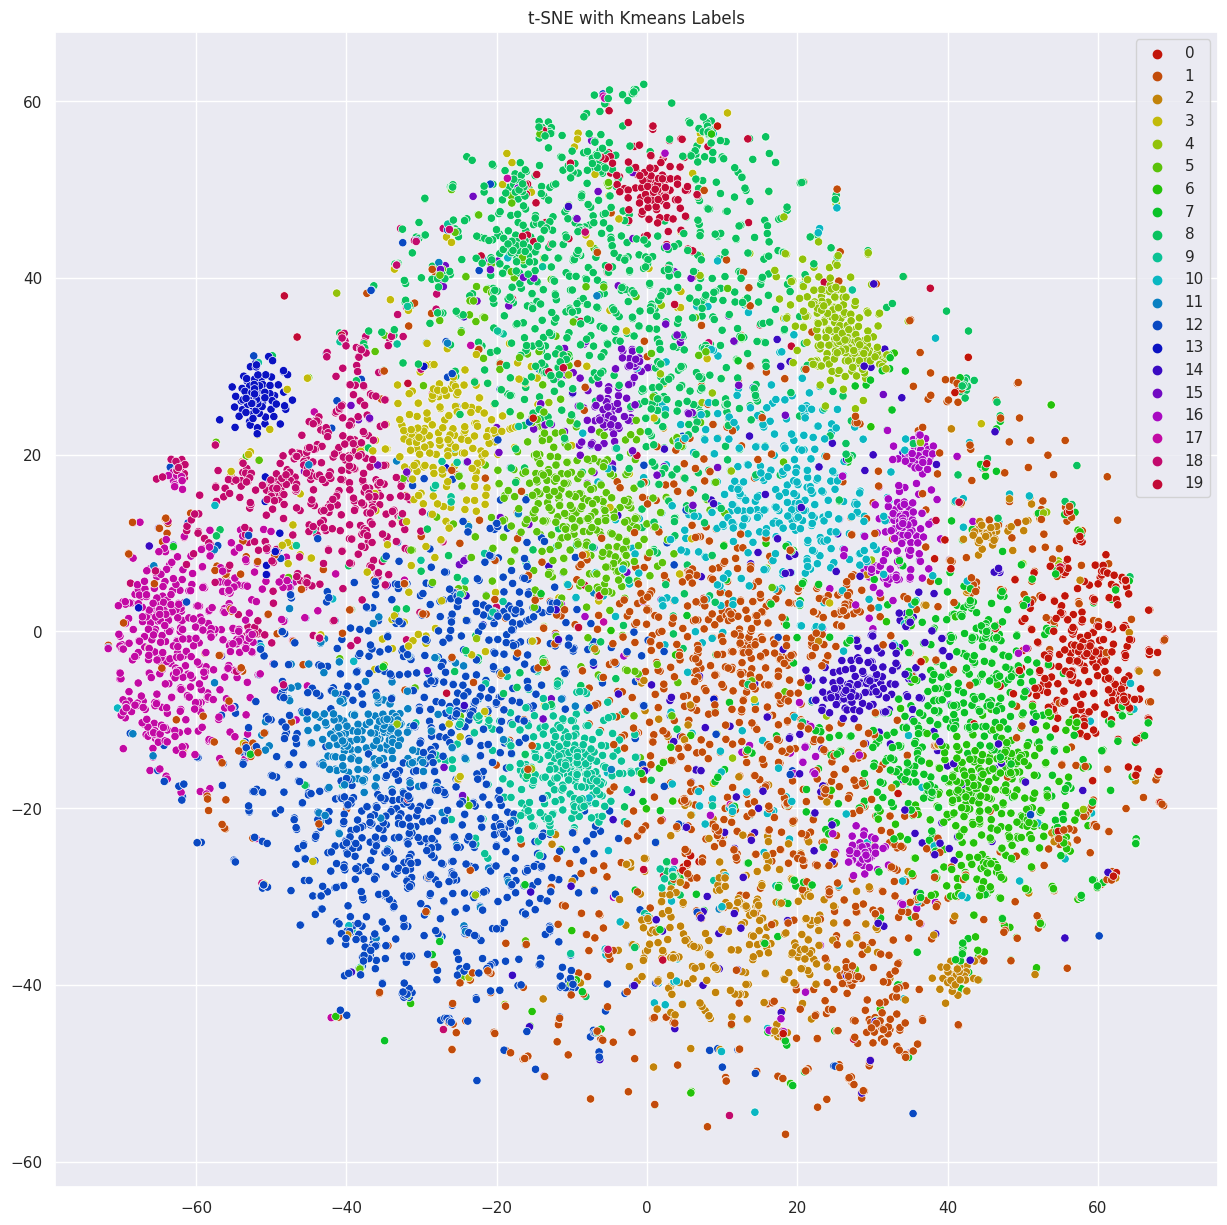

In [38]:
%matplotlib inline

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("cluster_tsne.png")
plt.show()

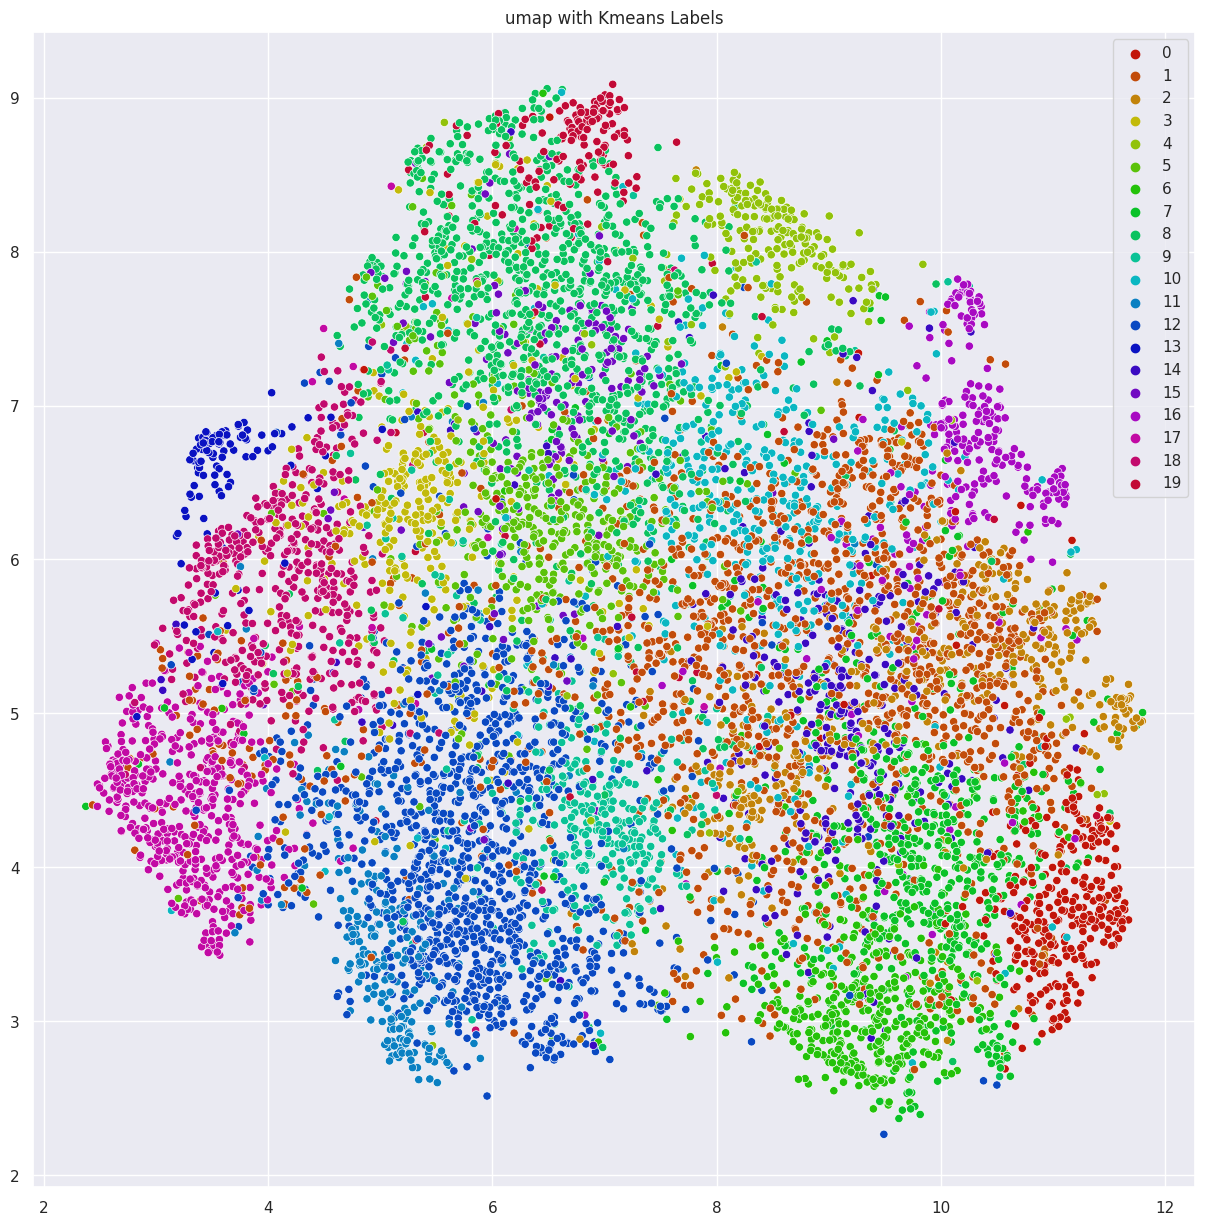

In [39]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('umap with Kmeans Labels')
plt.savefig("cluster_umap_kmeans_labels.png")
plt.show()

In [40]:
import plotly.express as px
fig = px.scatter(df, x=X_embedded[:,0], y=X_embedded[:,1], color=y_pred.astype(str),
                 hover_data=['id', 'authors', 'title',],
                 height= 1000, width=1000,
                title = "t-SNE with Kmeans Labels")
fig.show()

Output hidden; open in https://colab.research.google.com to view.